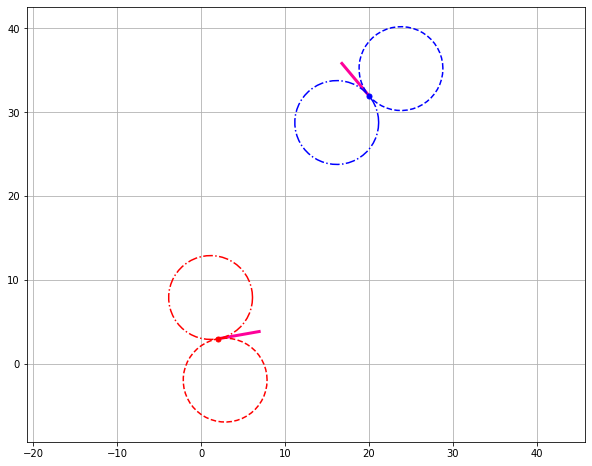

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import casadi

u = casadi.SX.sym('u')

def get_circle_pnt(u, pos, radius, offset=0.0):
    x = pos[0] + radius * np.cos(2 * np.pi * u + offset)
    y = pos[1] + radius * np.sin(2 * np.pi * u + offset)
    return x, y

def get_circle(pos, radius, offset=0.0):
    u = np.linspace(0, 1, 50)
    return get_circle_pnt(u, pos, radius, offset)

def get_frame(angle):
    return np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]])

radius = 5
wp_1 = np.array([2, 3])
heading_1 = 10 * np.pi / 180
wp_2 = np.array([20, 32])
heading_2 = 130 * np.pi / 180

frame_1 = get_frame(heading_1)
frame_2 = get_frame(heading_2)

center_1 = dict(R=wp_1 - radius * frame_1[:, 1].flatten(),
                L=wp_1 + radius * frame_1[:, 1].flatten())

center_2 = dict(R=wp_2 - radius * frame_2[:, 1].flatten(),
                L=wp_2 + radius * frame_2[:, 1].flatten())

def plot_base():
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    # Plot first waypoint's L and R circles
    ax.plot([wp_1[0], wp_1[0] + 5 * np.cos(heading_1)], [wp_1[1], wp_1[1] + 5 * np.sin(heading_1)], color='xkcd:neon pink', linewidth=3)
    ax.plot([wp_1[0]], [wp_1[1]], '.r', markersize=10)

    x, y = get_circle(center_1['L'], radius)
    ax.plot(x, y, '-.r')
    x, y = get_circle(center_1['R'], radius)
    ax.plot(x, y, '--r')

    # Plot second waypoint's L and R circles
    x, y = get_circle(wp_2, radius)
    ax.plot([wp_2[0], wp_2[0] + 5 * np.cos(heading_2)], [wp_2[1], wp_2[1] + 5 * np.sin(heading_2)], color='xkcd:neon pink', linewidth=3)
    ax.plot([wp_2[0]], [wp_2[1]], '.b', markersize=10)

    x, y = get_circle(center_2['L'], radius)
    ax.plot(x, y, '-.b')
    x, y = get_circle(center_2['R'], radius)
    ax.plot(x, y, '--b')

    ax.axis('equal')
    ax.grid(True)
    
    return ax
    
plot_base()

RSR


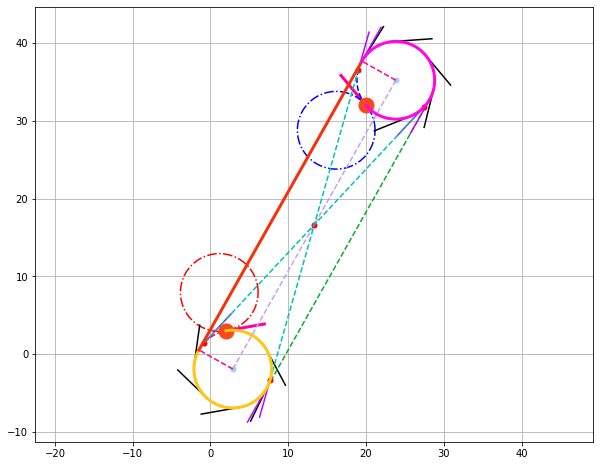

In [2]:
print('RSR')

u1 = casadi.SX.sym('u1')
u2 = casadi.SX.sym('u2')

def get_tangents(center_1, radius_1, heading_1, delta_1, center_2, radius_2, heading_2, delta_2):
    output = dict()
    
    phi_1 = 2 * np.pi * u1 * delta_1 + heading_1 - delta_1 * np.pi / 2
    phi_2 = 2 * np.pi * u2 * delta_2 + heading_2 - delta_2 * np.pi / 2
    
    u1_func = lambda angle: (angle - heading_1 + delta_1 * np.pi / 2) / (delta_1 * 2 * np.pi)
    u2_func = lambda angle: (angle - heading_2 + delta_2 * np.pi / 2) / (delta_2 * 2 * np.pi)
    # Make tangents vector functions
    tan_1 = casadi.cross(np.array([0, 0, 1]), 
                         np.array([delta_1 * radius * np.cos(phi_1), delta_1 * radius * np.sin(phi_1), 0]))[0:2]
    tan_2 = casadi.cross(np.array([0, 0, 1]), 
                         np.array([delta_2 * radius * np.cos(phi_2), delta_2 * radius * np.sin(phi_2), 0]))[0:2]
    
    # Make circle functions
    circle_1_func = center_1 + radius_1 * np.array([np.cos(phi_1), np.sin(phi_1)])
    circle_2_func = center_2 + radius_2 * np.array([np.cos(phi_2), np.sin(phi_2)])
    
    # Plot the circles
    ax = plot_base()
    
    ## Plot the circle center points
    ax.plot([center_1[0]], [center_1[1]], marker='.', color='xkcd:baby blue', markersize=10)
    ax.plot([center_2[0]], [center_2[1]], marker='.', color='xkcd:baby blue', markersize=10)

    ## Plot a couple of tangent vectors
    for i in np.linspace(0.2, 0.8, 5):
        c1 = casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [i])
        t1 = casadi.substitute(tan_1, casadi.vertcat(*[u1]), [i])
        t1 *= 5 / casadi.norm_2(t1)
        ax.plot([c1[0], c1[0] + t1[0]],
                [c1[1], c1[1] + t1[1]], 'k')

        c2 = casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [i])
        t2 = casadi.substitute(tan_2, casadi.vertcat(*[u2]), [i])
        t2 *= 5 / casadi.norm_2(t2)
        ax.plot([c2[0], c2[0] + t2[0]],
                [c2[1], c2[1] + t2[1]], 'k')
    
    ## Plot line connecting the circle centers
    ax.plot([center_1[0], center_2[0]], [center_1[1], center_2[1]], linestyle='--', color='xkcd:lavender')
    
    ## Plot the starting point of each circle
    c1 = casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [0])
    c2 = casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [0])
    ax.plot([c1[0]], [c1[1]], marker='o', color='xkcd:reddish orange', markersize=15)
    ax.plot([c2[0]], [c2[1]], marker='o', color='xkcd:reddish orange', markersize=15)
    
    # Compute the line connecting the circle's centers
    d = center_2 - center_1
    # Calculate normal vector to the connecting line
    n = np.dot(get_frame(np.pi / 2), d / np.linalg.norm(d))
    
    ## Plotting the normal vectors
    ax.plot([center_1[0], center_1[0] + radius_1 * n[0]], [center_1[1], center_1[1] + radius_1 * n[1]], linestyle='--', color='xkcd:hot pink')
    ax.plot([center_2[0], center_2[0] + radius_2 * n[0]], [center_2[1], center_2[1] + radius_2 * n[1]], linestyle='--', color='xkcd:hot pink')
        
    ##########################################################
    # Compute the first tangent
    ## Compute the normal vector's angle
    n_angle = np.arctan2(n[1], n[0])    
    ## Compute the parameter for the tangent points on both circles
    u1_opt = u1_func(n_angle)    
    if u1_opt < 0:
        u1_opt = u1_opt + 1 
    u2_opt = u2_func(n_angle)
    if u2_opt < 0:
        u2_opt = u2_opt + 1
        
    ## Compute the points on the circles for the first tangent
    c1 = casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [u1_opt])
    c2 = casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [u2_opt])
    
    tangent_1 = c2 - c1
    tangent_1 /= casadi.norm_2(tangent_1)
                
    ax.plot([c1[0], c2[0]], [c1[1], c2[1]], linestyle='--', color='xkcd:kelly green')
    
    ## Compute the tangent vectors on the circles
    t1 = casadi.substitute(tan_1, casadi.vertcat(*[u1]), [u1_opt])
    t1 /= casadi.norm_2(t1)
    t2 = casadi.substitute(tan_2, casadi.vertcat(*[u2]), [u2_opt])
    t2 /= casadi.norm_2(t2)
    
    diff = float(casadi.norm_2(tangent_1 - t1) + casadi.norm_2(tangent_1 - t2))
    
    if np.isclose(diff, 0):
        u = np.arange(0, u1_opt, 0.001)        
        output['C1'] = [casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [ui]) for ui in u]
        output['S'] = [casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [u1_opt]), casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [u2_opt])]
        u = np.arange(u2_opt, 1, 0.001)
        output['C2'] = [casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [ui]) for ui in u]
    
    ## Plot the tangent vectors on the circles that are parallel to the first tangent 
    ax.plot([c1[0], c1[0] + radius_1 * t1[0]], [c1[1], c1[1] + radius_1 * t1[1]], linestyle='-', color='xkcd:bright purple')
    ax.plot([c2[0], c2[0] + radius_2 * t2[0]], [c2[1], c2[1] + radius_2 * t2[1]], linestyle='-', color='xkcd:bright purple')
    
    ##########################################################
    # Compute the second tangent    
    n_angle = np.arctan2(-n[1], -n[0])
    u1_opt = u1_func(n_angle)    
    if u1_opt < 0:
        u1_opt = u1_opt + 1 
    u2_opt = u2_func(n_angle)
    if u2_opt < 0:
        u2_opt = u2_opt + 1

    c1 = casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [u1_opt])
    c2 = casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [u2_opt])
    
    tangent_2 = c2 - c1
    tangent_2 /= casadi.norm_2(tangent_2)

    ## Plotting the second tangent
    ax.plot([c1[0], c2[0]], [c1[1], c2[1]], linestyle='--', color='xkcd:kelly green')
    
    ## Compute the tangent vectors on the circles
    t1 = casadi.substitute(tan_1, casadi.vertcat(*[u1]), [u1_opt])
    t1 /= casadi.norm_2(t1)
    t2 = casadi.substitute(tan_2, casadi.vertcat(*[u2]), [u2_opt])
    t2 /= casadi.norm_2(t2)
    
    diff = float(casadi.norm_2(tangent_2 - t1) + casadi.norm_2(tangent_2 - t2))

    if np.isclose(diff, 0):
        u = np.arange(0, u1_opt, 0.001)        
        output['C1'] = [casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [ui]) for ui in u]
        output['S'] = [casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [u1_opt]), casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [u2_opt])]
        u = np.arange(u2_opt, 1, 0.001)
        output['C2'] = [casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [ui]) for ui in u]
    
    ## Plot the tangent vectors on the circles that are parallel to the second tangent 
    ax.plot([c1[0], c1[0] + radius_1 * t1[0]], [c1[1], c1[1] + radius_1 * t1[1]], linestyle='-', color='xkcd:bright purple')
    ax.plot([c2[0], c2[0] + radius_2 * t2[0]], [c2[1], c2[1] + radius_2 * t2[1]], linestyle='-', color='xkcd:bright purple')

    ##########################################################
    # Computing inner tangents
    # Calculate the intersection point of the two tangent lines
    xp = (center_1[0] * radius_1 + center_2[0] * radius_2) / (radius_1 + radius_2)
    yp = (center_1[1] * radius_1 + center_2[1] * radius_2) / (radius_1 + radius_2)

    ax.plot([xp], [yp], '.r', markersize=10)
    # Third and fourth tangents
    xt1 = (radius_1**2 * (xp - center_1[0]) + radius_1 * (yp - center_1[1]) * np.sqrt((xp - center_1[0])**2 + (yp - center_1[1])**2 - radius_1**2)) / ((xp - center_1[0])**2 + (yp - center_1[1])**2) + center_1[0]
    xt2 = (radius_1**2 * (xp - center_1[0]) - radius_1 * (yp - center_1[1]) * np.sqrt((xp - center_1[0])**2 + (yp - center_1[1])**2 - radius_1**2)) / ((xp - center_1[0])**2 + (yp - center_1[1])**2) + center_1[0]

    yt1 = ((radius_1**2 * (yp - center_1[1])) - radius_1 * (xp - center_1[0]) * np.sqrt((xp - center_1[0])**2 + (yp - center_1[1])**2 - radius_1**2)) / ((xp - center_1[0])**2 + (yp - center_1[1])**2) + center_1[1]
    yt2 = ((radius_1**2 * (yp - center_1[1])) + radius_1 * (xp - center_1[0]) * np.sqrt((xp - center_1[0])**2 + (yp - center_1[1])**2 - radius_1**2)) / ((xp - center_1[0])**2 + (yp - center_1[1])**2) + center_1[1]

    ## Plotting the tangent points on the first circle
    ax.plot([xt1, xt2], [yt1, yt2], '.r', markersize=10)

    xt3 = (radius_2**2 * (xp - center_2[0]) + radius_2 * (yp - center_2[1]) * np.sqrt((xp - center_2[0])**2 + (yp - center_2[1])**2 - radius_2**2)) / ((xp - center_2[0])**2 + (yp - center_2[1])**2) + center_2[0]
    xt4 = (radius_2**2 * (xp - center_2[0]) - radius_2 * (yp - center_2[1]) * np.sqrt((xp - center_2[0])**2 + (yp - center_2[1])**2 - radius_2**2)) / ((xp - center_2[0])**2 + (yp - center_2[1])**2) + center_2[0]

    yt3 = ((radius_2**2 * (yp - center_2[1])) - radius_2 * (xp - center_2[0]) * np.sqrt((xp - center_2[0])**2 + (yp - center_2[1])**2 - radius_2**2)) / ((xp - center_2[0])**2 + (yp - center_2[1])**2) + center_2[1]
    yt4 = ((radius_2**2 * (yp - center_2[1])) + radius_2 * (xp - center_2[0]) * np.sqrt((xp - center_2[0])**2 + (yp - center_2[1])**2 - radius_2**2)) / ((xp - center_2[0])**2 + (yp - center_2[1])**2) + center_2[1]

    ## Plotting the tangent points on the second circle
    ax.plot([xt3, xt4], [yt3, yt4], '.r', markersize=10)
    
    # Third tangent
    u1_opt = u1_func(np.arctan2(yt1 - center_1[1], xt1 - center_1[0]))
    if u1_opt < 0:
        u1_opt = u1_opt + 1     
    u2_opt = u2_func(np.arctan2(yt3 - center_2[1], xt3 - center_2[0]))
    if u2_opt < 0:
        u2_opt = u2_opt + 1
    
    c1 = casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [u1_opt])
    c2 = casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [u2_opt])
    
    t1 = casadi.substitute(tan_1, casadi.vertcat(*[u1]), [u1_opt])
    t1 /= casadi.norm_2(t1)
    t2 = casadi.substitute(tan_2, casadi.vertcat(*[u2]), [u2_opt])
    t2 /= casadi.norm_2(t2)
    
    ## Plot the tangent vectors on the circles that are parallel to the third tangent 
    ax.plot([c1[0], c1[0] + radius_1 * t1[0]], [c1[1], c1[1] + radius_1 * t1[1]], linestyle='-', color='xkcd:bright purple')
    ax.plot([c2[0], c2[0] + radius_2 * t2[0]], [c2[1], c2[1] + radius_2 * t2[1]], linestyle='-', color='xkcd:bright purple')
    
    tangent_3 = np.array([xt3 - xt1, yt3 - yt1])
    tangent_3 /= np.linalg.norm(tangent_3)
        
    diff = float(casadi.norm_2(tangent_3 - t1) + casadi.norm_2(tangent_3 - t2))
    
    if np.isclose(diff, 0):
        u = np.arange(0, u1_opt, 0.001)        
        output['C1'] = [casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [ui]) for ui in u]
        output['S'] = [casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [u1_opt]), casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [u2_opt])]
        u = np.arange(u2_opt, 1, 0.001)
        output['C2'] = [casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [ui]) for ui in u]
    
    # Fourth tangent
    u1_opt = u1_func(np.arctan2(yt2 - center_1[1], xt2 - center_1[0]))
    if u1_opt < 0:
        u1_opt = u1_opt + 1
    u2_opt = u2_func(np.arctan2(yt4 - center_2[1], xt4 - center_2[0]))
    if u2_opt < 0:
        u2_opt = u2_opt + 1
    
    c1 = casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [u1_opt])
    c2 = casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [u2_opt])
    
    t1 = casadi.substitute(tan_1, casadi.vertcat(*[u1]), [u1_opt])
    t1 /= casadi.norm_2(t1)
    t2 = casadi.substitute(tan_2, casadi.vertcat(*[u2]), [u2_opt])
    t2 /= casadi.norm_2(t2)
    
    ## Plot the tangent vectors on the circles that are parallel to the fourth tangent 
    ax.plot([c1[0], c1[0] + radius_1 * t1[0]], [c1[1], c1[1] + radius_1 * t1[1]], linestyle='-', color='xkcd:bright purple')
    ax.plot([c2[0], c2[0] + radius_2 * t2[0]], [c2[1], c2[1] + radius_2 * t2[1]], linestyle='-', color='xkcd:bright purple')
    
    tangent_4 = np.array([xt4 - xt2, yt4 - yt2])
    tangent_4 /= np.linalg.norm(tangent_4)
    
    diff = float(casadi.norm_2(tangent_4 - t1) + casadi.norm_2(tangent_4 - t2))
    
    if np.isclose(diff, 0):
        u = np.arange(0, u1_opt, 0.001)        
        output['C1'] = [casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [ui]) for ui in u]
        output['S'] = [casadi.substitute(circle_1_func, casadi.vertcat(*[u1]), [u1_opt]), casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [u2_opt])]
        u = np.arange(u2_opt, 1, 0.001)
        output['C2'] = [casadi.substitute(circle_2_func, casadi.vertcat(*[u2]), [ui]) for ui in u]

    ax.plot([xt1, xt3], [yt1, yt3], '--c')
    ax.plot([xt2, xt4], [yt2, yt4], '--c')
    
    #########################################################
    # Plot the path            
    ax.plot([x[0] for x in output['C1']], [x[1] for x in output['C1']], color='xkcd:golden yellow', linewidth=3)
    ax.plot([x[0] for x in output['S']], [x[1] for x in output['S']], color='xkcd:vermillion', linewidth=3)
    ax.plot([x[0] for x in output['C2']], [x[1] for x in output['C2']], color='xkcd:bright magenta', linewidth=3)

get_tangents(center_1['R'], radius, heading_1, -1, center_2['R'], radius, heading_2, -1)
    

LSR


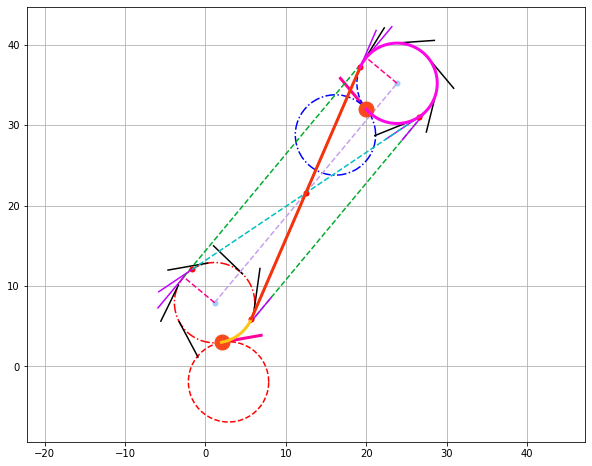

In [3]:
print('LSR')

u1 = casadi.SX.sym('u1')
u2 = casadi.SX.sym('u2')

get_tangents(center_1['L'], radius, heading_1, 1, center_2['R'], radius, heading_2, -1)

RSL


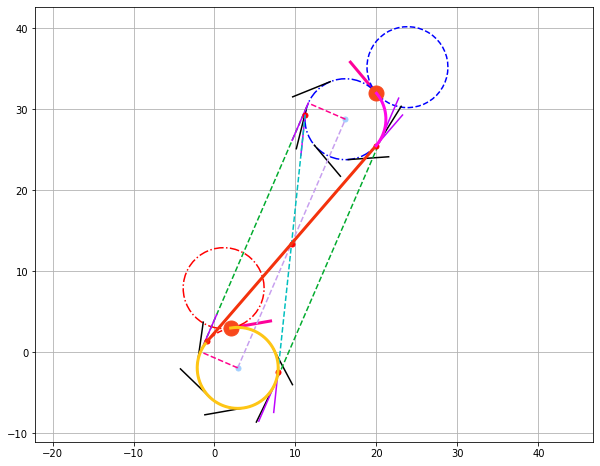

In [4]:
print('RSL')

get_tangents(center_1['R'], radius, heading_1, -1, center_2['L'], radius, heading_2, 1)

LSL


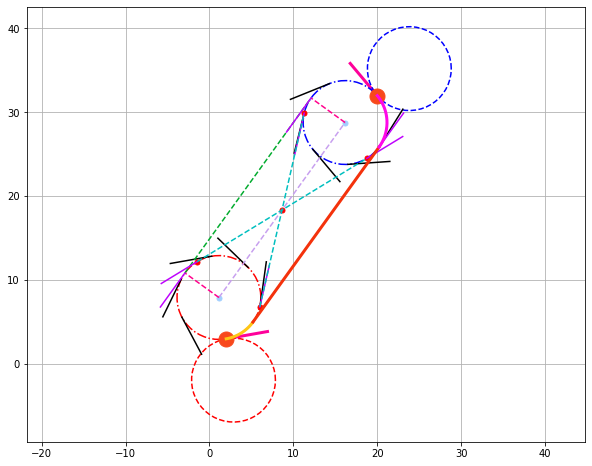

In [5]:
print('LSL')

get_tangents(center_1['L'], radius, heading_1, 1, center_2['L'], radius, heading_2, 1)